In [1]:
def explore():
    # This Python 3 environment comes with many helpful analytics libraries installed
    # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
    # For example, here's several helpful packages to load
    
    import numpy as np # linear algebra
    import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
    from pathlib import Path
    
    # Input data files are available in the read-only "../input/" directory
    # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
    
    import os
    sortme = []
    for dirname, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames:
            full_path = Path(dirname)/filename
            sortme.append(str(full_path))
            '''if full_path.suffix.lower().strip('.') in ['py', 'yaml', 'csv', 'bat'] or full_path.name == 'classes.txt':
                prefix = '/kaggle/input/synthetic-2-real-object-detection-challenge/Synthetic to Real Object Detection Challenge/'
                print(f'## [{str(full_path).removeprefix(prefix)}] ##')
                print(full_path.read_text())'''
            
    sortme.sort()
    for path in sortme:
        print(path)
    # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
    # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

#explore()

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision
from torchvision.transforms import v2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path

import PIL

from tqdm import tqdm

In [3]:
## Device agnostic code and set the image size to use
IMAGE_SIZE_SQUARE = 512

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_device(device)
print(f"Default device set to --> {device}")

Default device set to --> cpu


## Set root directories for each dataset

In [4]:
root_data_dir = Path('/kaggle/input/synthetic-2-real-object-detection-challenge/Synthetic to Real Object Detection Challenge/data/')
train_data_dir, eval_data_dir, test_data_dir = (root_data_dir / x for x in ['train', 'val', 'test'])
train_data_dir, eval_data_dir, test_data_dir

(PosixPath('/kaggle/input/synthetic-2-real-object-detection-challenge/Synthetic to Real Object Detection Challenge/data/train'),
 PosixPath('/kaggle/input/synthetic-2-real-object-detection-challenge/Synthetic to Real Object Detection Challenge/data/val'),
 PosixPath('/kaggle/input/synthetic-2-real-object-detection-challenge/Synthetic to Real Object Detection Challenge/data/test'))

## Check for corrupted images

In [5]:
ok = 0
errors = []
image_extensions = {}
for data_dir in [train_data_dir, eval_data_dir, test_data_dir]:
    dataset_name = data_dir.stem
    image_extensions[dataset_name] = set()
    for image_path in tqdm(list((data_dir / 'images').iterdir()), desc=dataset_name):
        if image_path.suffix.lower() not in {'.png', '.jpg', '.jpeg'}:
            continue
        try:
            # assume the image to not be corrupted if pillow can load it
            PIL.Image.open(image_path).load()
            ok += 1
        except Exception as e:
            errors.append((image_path, e))
for image_path, e in errors:
    print(image_path)
    print(e)
    print()
print(f'Images loaded successfuly: {ok}. Images that couldn\'t be loaded: {len(errors)}.')

test: 100%|██████████| 165/165 [00:11<00:00, 14.43it/s]

Images loaded successfuly: 664. Images that couldn't be loaded: 0.


In [6]:
# these functions don't care if the input is relative or absolute.
# if inputs are absolute, return values are absolute and
# if inputs are relative, return values are relative

def yolo_to_xy(x_center, y_center, w, h):
    xmin = x_center - w/2
    xmax = x_center + w/2
    ymin = y_center - h/2
    ymax = y_center + h/2
    
    return xmin, ymin, xmax, ymax

def xy_to_yolo(x1, y1, x2, y2):
    xmin = min(x1, x2)
    xmax = max(x1, x2)
    ymin = min(y1, y2)
    ymax = max(y1, y2)
    
    width = xmax - xmin
    height = ymax - ymin
    x_center = (xmin + xmax) / 2
    y_center = (ymin + ymax) / 2


    return (
        x_center,
        y_center,
        width,
        height
    )


#0 0.4231770833333333 0.4324074074074074 0.2140625 0.46296296296296297

# Since the function keeps everything within the same floating range, there~s gonna be some lost information 
x1, y1, x2, y2 = yolo_to_xy(0.4231770833333333, 0.4324074074074074, 0.2140625, 0.46296296296296297)
xy_to_yolo(x1, y1, x2, y2)

(0.4231770833333333,
 0.4324074074074074,
 0.21406249999999993,
 0.4629629629629629)

In [7]:
class CheeriosDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform_image=None, transform_image_bbox=None, target_transform=None):
        self.root_dir = Path(root_dir)
        self.image_dir = self.root_dir / 'images'
        self.label_dir = self.root_dir / 'labels'
        self.transform_image = transform_image
        self.transform_image_bbox = transform_image_bbox
        self.target_transform = target_transform
        self.image_file_paths = []
        self.data_pairs = []
        
        for image_path in self.image_dir.iterdir():
            if image_path.suffix.lower() not in {'.jpeg', '.jpg', '.png'}:
                continue  # ignore if it's not an image
            self.image_file_paths.append(image_path)
            
        self.image_file_paths.sort()


        # assign the corresponding label for each image, storing the assignments in data_pairs
        for image_path in self.image_file_paths:
            label_path = self.label_dir / image_path.with_suffix('.txt').name
            text_content = label_path.read_text().strip() if label_path.is_file() else None
            all_labels = []
            if text_content:
                for line in text_content.splitlines():
                    _, center_x, center_y, width, height = map(float, line.strip().split())
                    all_labels.append([1, center_x, center_y, width, height])
                self.data_pairs.append((image_path, all_labels))
            else:
                self.data_pairs.append((image_path, []))

        # initialize cache to prevent loading the same file more than once
        self.image_cache = [None] * len(self.image_file_paths)

    def __len__(self):
        return len(self.data_pairs)

    def __getitem__(self, idx):
        image_path, label = self.data_pairs[idx]
        if self.image_cache[idx] is None:
            pilimg = PIL.Image.open(image_path).convert('RGB')
            image_tensor = v2.functional.pil_to_tensor(pilimg).type(torch.uint8)
            image = torchvision.tv_tensors.Image(image_tensor)
            self.image_cache[idx] = image
        else:
            image = self.image_cache[idx]

        orig_height, orig_width = image.shape[1:]

        # create a list of lists (for some reason using a tensor here throws a mysterious exception)
        # only create in case label is existent
        retlabel = torch.tensor([]) # for in case there is no label, it will just return an empty tensor
        if label != []:
            bboxes = []
            for label_line in label:
                _, cx_norm, cy_norm, w_norm, h_norm = label_line
                bboxes.append(
                    # convert everything to xyxy
                    list(yolo_to_xy(
                        (cx_norm * orig_width),
                        (cy_norm * orig_height),
                        (w_norm * orig_width),
                        (h_norm * orig_height)
                    ))
                )
    
            bboxes_tv = torchvision.tv_tensors.BoundingBoxes(
                bboxes,
                format='XYXY',
                canvas_size=image.shape[-2:]
            )
            
            if self.transform_image_bbox:
                if bboxes:
                    image, bboxes_tv = self.transform_image_bbox(image, bboxes_tv)
                else:
                    image = self.transform_image_bbox(image)
            
            if self.transform_image:
                image = self.transform_image(image)
    
            if len(bboxes_tv) > 0:
                # convert the silly list of lists back into a tensor
                retlabel = torch.tensor([list(xy_to_yolo(*label_line)) for label_line in bboxes_tv])
                
            else:
                retlabel = torch.zeros((0, 4), dtype=torch.float32)
    
            if self.target_transform:
                retlabel = self.target_transform(retlabel)
        
        return image, retlabel


## Basic EDA: check how many positives and negatives

In [8]:
from collections import Counter
train_dataset = CheeriosDataset(train_data_dir)
eval_dataset = CheeriosDataset(eval_data_dir)
test_dataset = CheeriosDataset(test_data_dir)
union = train_dataset.data_pairs #+ eval_dataset.data_pairs

c = Counter()
for _, label in union:  # avoid loading the images
    c[len(label)] += 1
print(f"Images with/wihout a cheerio box {c}")

Images with/wihout a cheerio box Counter({1: 424, 0: 7})


In [9]:
# transforms that only apply to the pixels themselves
transform_image = v2.Compose([
    v2.ToDtype(torch.float32, scale=True),
    v2.GaussianBlur(kernel_size=5, sigma=(0.001, 2.0)),
    v2.GaussianNoise(sigma=0.05),
    v2.ToDtype(torch.uint8, scale=True),
    v2.RandomChoice([
        v2.ColorJitter(
            brightness=0.8,
            contrast=0.8,
            saturation=0.8,
            hue=0.2
        ),
        v2.RandomPosterize(bits=3),
        v2.RandomSolarize(threshold=0.5),
    ]),
    v2.JPEG(quality=(50, 100)),
])

# transforms that apply to the pixels and/or the bounding boxes
transform_image_bbox =  v2.Compose([
    v2.Resize((IMAGE_SIZE_SQUARE, IMAGE_SIZE_SQUARE)),
    v2.RandomHorizontalFlip(0.2),
    v2.RandomVerticalFlip(0.2),
    v2.RandomAffine(
        degrees=(-60, 60),
        translate=(0.3, 0.3),
        scale=(0.5, 1.5),
        shear=(-30, 30)
    ),

    # using SanitizeBoundingBoxes here is scary because we only have one bbox per datapoint
])


In [10]:
train_dataset = CheeriosDataset(train_data_dir, transform_image, transform_image_bbox)
train_dataset_no_transforms = CheeriosDataset(train_data_dir, None, None)
eval_dataset = CheeriosDataset(eval_data_dir, transform_image, transform_image_bbox)

## Visualize a random image + bbox after being transformed

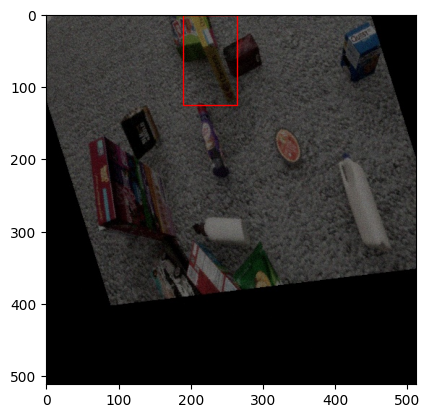

In [11]:
from matplotlib.patches import Rectangle

dl = torch.utils.data.DataLoader(train_dataset, shuffle=1)

image, label = next(iter(dl))

plt.imshow(torch.permute(image.squeeze(), (1, 2, 0)))
ax = plt.gca()
for bbox in label[0]:
    # to make things maybe simpler, `label` doesn't contain the class,
    # it's just the bounding box in centerx, centery, width, height format.
    # IMPORTANT: the coordinates of the bounding box are ABSOLUTE. to convert to relative
    # do `bbox = bbox/IMAGE_SIZE_SQUARE`
    ax.add_patch(Rectangle((
        bbox[0] - bbox[2]/2,
        bbox[1] - bbox[3]/2
    ), bbox[2], bbox[3],linewidth=1,edgecolor='r',facecolor='none'))

# Visualize an image both with and without the transformation

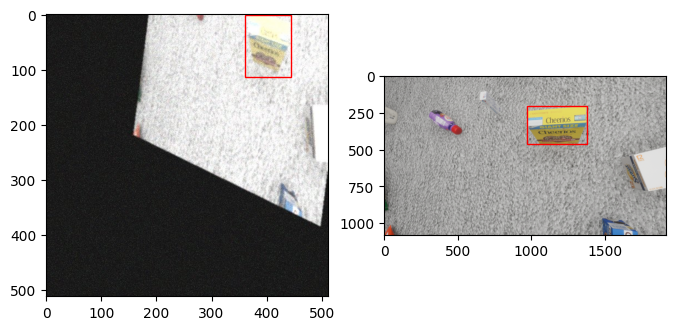

In [12]:
from matplotlib.patches import Rectangle

dataloaders = [torch.utils.data.DataLoader(train_dataset, shuffle=0), torch.utils.data.DataLoader(train_dataset_no_transforms, shuffle=0)]

labels = []
fig, axis = plt.subplots(1, 2, figsize=(8, 16))
for ax_idx in range(2):
    image, label = next(iter(dataloaders[ax_idx]))
    labels.append(label)
    axis[ax_idx].imshow(torch.permute(image.squeeze(), (1, 2, 0)))
ax = plt.gca()
for idx, label in enumerate(labels):
    for bbox in label[0]:
        # to make things maybe simpler, `label` doesn't contain the class,
        # it's just the bounding box in centerx, centery, width, height format.
        # IMPORTANT: the coordinates of the bounding box are ABSOLUTE. to convert to relative
        # do `bbox = bbox/IMAGE_SIZE_SQUARE`
        axis[idx].add_patch(Rectangle((
            bbox[0] - bbox[2]/2,
            bbox[1] - bbox[3]/2
        ), bbox[2], bbox[3],linewidth=1,edgecolor='r',facecolor='none'))

# Work with Yolo model

In [13]:
pip install git+https://github.com/ultralytics/ultralytics.git@main

  Cloning https://github.com/ultralytics/ultralytics.git (to revision main) to /tmp/pip-req-build-yv9vvslo
  Running command git clone --filter=blob:none --quiet https://github.com/ultralytics/ultralytics.git /tmp/pip-req-build-yv9vvslo
  Resolved https://github.com/ultralytics/ultralytics.git to commit dbe2b5d4bb27803e150a7e5fea4b5d4449032690
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for ultralytics: filename=ultralytics-8.3.104-py3-none-any.whl size=994144 sha256=798a02bdb3284ab40f5d92aac56bfbdd0282034293eeeb0c01d8bf886598286d
  Stored in directory: /tmp/pip-ephem-wheel-cache-1ggn45if/wheels/60/db/e5/6abbdd13b4e3d5e2fdcd87690cd8738f842eeb37142fdccb5b
Successfully built ultralytics
Note: you may need to restart the kernel to use updated packages.


In [14]:
from ultralytics import YOLO
import cv2

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [15]:
model = YOLO("yolov8n-seg.pt")

100%|██████████| 6.74M/6.74M [00:00<00:00, 86.0MB/s]


# Image test for segmentation


0: 640x448 1 person, 274.8ms
Speed: 15.6ms preprocess, 274.8ms inference, 15.3ms postprocess per image at shape (1, 3, 640, 448)


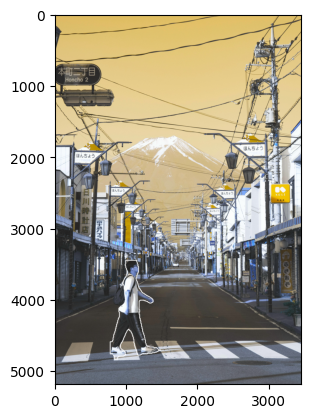

In [16]:
#image = train_dataset[0]
# For YOLO, image pixels must be between 0-1, so must divide by 255
# Might do it in the dataset itself later for pre-processing

image = cv2.imread("/kaggle/input/test-image/pexels-xenofan-696995602-31006027aaaaa.jpg")
preds = model.predict(image, conf=0.5)
for pred in preds:
    #print(pred.masks.xy)
    #print(pred.boxes)
    for mask in pred.masks.xy:
        box_coords = np.int32([mask])
        cv2.polylines(image, box_coords, isClosed=True, color=(255, 255, 255), thickness=10)


plt.imshow(image)
plt.show()

In [17]:
!mkdir ./torch_modified_dataset

# Adding more data to dataset using pytorch

In [18]:
train_dataset = CheeriosDataset(train_data_dir, transform_image, transform_image_bbox)
train_dataloader = DataLoader(train_dataset, shuffle=True, generator=torch.Generator(device=device))
test_dataloader = DataLoader(test_dataset, shuffle=True, generator=torch.Generator(device=device))
eval_dataloader = DataLoader(eval_dataset, shuffle=True, generator=torch.Generator(device=device))
dataloaders = {"train": train_dataloader, "test": test_dataloader, "eval": eval_dataloader}

In [19]:
!mkdir -p /kaggle/working/torch_modified_dataset/data/train/images
!mkdir -p /kaggle/working/torch_modified_dataset/data/train/labels

!mkdir -p /kaggle/working/torch_modified_dataset/data/test/images
!mkdir -p /kaggle/working/torch_modified_dataset/data/test/labels

!mkdir -p /kaggle/working/torch_modified_dataset/data/eval/images
!mkdir -p /kaggle/working/torch_modified_dataset/data/eval/labels

!rsync -aP --exclude=data "/kaggle/input/synthetic-2-real-object-detection-challenge/Synthetic to Real Object Detection Challenge/"* /kaggle/working/torch_modified_dataset

sending incremental file list
classes.txt
             10 100%    0.00kB/s    0:00:00 (xfr#1, to-chk=9/10)
convert_preds_to_csv.py
          3,868 100%    1.23MB/s    0:00:00 (xfr#2, to-chk=8/10)
predict.py
          3,734 100%  607.75kB/s    0:00:00 (xfr#3, to-chk=7/10)
sample_submission.csv
         14,556 100%    1.39MB/s    0:00:00 (xfr#4, to-chk=6/10)
train.py
          5,647 100%  290.24kB/s    0:00:00 (xfr#5, to-chk=5/10)
yolo_params.yaml
            283 100%   12.56kB/s    0:00:00 (xfr#6, to-chk=4/10)
ENV_SETUP/
ENV_SETUP/create_env.bat
            334 100%   13.05kB/s    0:00:00 (xfr#7, to-chk=2/10)
ENV_SETUP/install_packages.bat
          1,059 100%   34.47kB/s    0:00:00 (xfr#8, to-chk=1/10)
ENV_SETUP/setup_env.bat
            245 100%    7.25kB/s    0:00:00 (xfr#9, to-chk=0/10)


In [20]:
torch_dataset_root_dir = "/kaggle/working/torch_modified_dataset"
for k, dl in dataloaders.items():
    print(f"{root_data_dir}/{k}")
    for idx, (image, label) in tqdm(enumerate(dl)):
        #PIL.Image.fromarray(image.squeeze().cpu().numpy()).save(f"./{k}_{idx}")
        torchvision.utils.save_image(image.squeeze()/255, f"{torch_dataset_root_dir}/data/{k}/{k}_{idx}.png")
        print(label.squeeze().cpu().numpy())
        break

/kaggle/input/synthetic-2-real-object-detection-challenge/Synthetic to Real Object Detection Challenge/data/train


0it [00:00, ?it/s]


[     316.29      240.76      203.56      140.75]
/kaggle/input/synthetic-2-real-object-detection-challenge/Synthetic to Real Object Detection Challenge/data/test


0it [00:00, ?it/s]


[]
/kaggle/input/synthetic-2-real-object-detection-challenge/Synthetic to Real Object Detection Challenge/data/eval


0it [00:00, ?it/s]

[     162.86      97.468      102.19      194.94]
